## 10.7 Transformer

### 10.7.1 模型

Transformer的编码器和解码器都是基于自注意力的模块叠加而成的，其模型架构如下图所示。

![](../images/10-7-1.svg)

对于Transformer的编码器而言，其每个层都有两个子层，一个是**多头自注意力**，另一个是**基于位置的前馈网络**，同时度每个子层进行了残差连接。在Transformer中，对于序列中任何位置输入$\bm{x}\in\mathbb{R}^d$，都要满足每个子层的输出拥有相同的维度大小，也就是$\mathrm{sublayer}(\bm{x})\in\mathbb{R}^d$，以便其中的残差连接有效进行。

Transformer的解码器也使用了残差连接，并在其中插入了一个**编解码器注意力**，这里就不是一个自注意力操作了，但是解码器中的每个位置都只能考虑该位置之前的所有位置。同样使用**掩蔽注意力**的方法保留了自回归属性，确保了预测仅依赖于已生成的输出词元。

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

### 10.7.2 基于位置的前馈网络

该网络对序列中的所有位置的表示进行变换，使用一个多层感知机即可。

In [2]:
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

上述的网络是针对输入张量的最底层进行变换和改变尺寸的，使用同一个MLP对所有位置上的输入进行变换。

In [3]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 8])

### 10.7.3 残差连接和层规范化

也就是在一个小批量内进行加和和规范化。

In [4]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm: ', ln(X), '\nbatch norm: ', bn(X))

layer norm:  tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm:  tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


现在使用残差连接和层规范化来实现`AddNorm`类。

In [5]:
#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

很明显，其要求两个输入的形状相同。

In [6]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

### 10.7.4 编码器

下面先来实现编码器的一个层，也就是还没有乘上$n$个之前的单位。

1.0.3版本的d2l库中的`MultiHeadAttention`不一致，我们使用在[10.5节](10-5.ipynb)中实现的版本。

In [7]:
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
    
    def forward(self, queries, keys, values, valid_lens):
        """
        queries, keys, values的相同形状：
        (batch_size, 查询或键值对的个数, num_hiddens) \\
        valid_lens的形状:
        (batch_size, )或(batch_size, 查询的个数) \\
        经过变换后，输出的queries, keys, values的形状：
        (batch_size*num_heads, 查询或键值对的个数, num_hiddens/num_heads)
        """
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        
        # output.shape:
        # (batch_size*num_heads, 查询的个数, num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat.shape:
        # (batch_size, 查询的个数, num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

def transpose_qkv(X, num_heads):
    """
    为了多头注意力计算而改变形状

    shapes:
    input X: (batch_size, 查询或键值对的个数, num_hiddens)
    output X: (batch_size*num_heads, 查询或键值对的个数, num_hiddens/num_heads)
    """
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [8]:
#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, 
                 key_size, 
                 query_size, 
                 values_size,
                 num_hiddens,
                 norm_shape, 
                 ffn_num_input, 
                 ffn_num_hiddens, 
                 num_heads,
                 dropout,
                 use_bias=False,
                 **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.attention = MultiHeadAttention(
            key_size=key_size,
            query_size=query_size,
            value_size=values_size,
            num_hiddens=num_hiddens,
            num_heads=num_heads,
            dropout=dropout,
            bias=use_bias,
        )
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input=ffn_num_input,
            ffn_num_hiddens=ffn_num_hiddens,
            ffn_num_outputs=num_hiddens,
        )
        self.addnorm2 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

在上述代码中可以看到，无论什么时候，Transformer编码器中的任何层都不会改变其输入形状。

In [9]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

下面对其进行堆叠，也就是堆叠`num_layers`个`EncoderBlock`的实例。

由于这里使用的是固定位置编码，因此通过学习的到的输入需要进行重新的缩放再与位置编码相加。

下面使用到了`nn.Embedding`模块，这是一个类似`nn.Linear`的模块，不过其进行了一个one-hot编码的操作后再通过全连接。

In [10]:
#@save 
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self,
                 vocab_size, 
                 key_size, 
                 query_size, 
                 value_size, 
                 num_hiddens, 
                 norm_shape, 
                 ffn_num_input, 
                 ffn_num_hiddens,
                 num_heads, 
                 num_layers, 
                 dropout, 
                 use_bias=False,
                 **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)

        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(
                    key_size,
                    query_size, 
                    value_size, 
                    num_hiddens,
                    norm_shape,
                    ffn_num_input,
                    ffn_num_hiddens,
                    num_heads,
                    dropout,
                    use_bias,
                ),
            )
        
    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

下面来创建一个两层的Transformer编码器，其输出的形状为`(batch_size, 时间步数目, num_hiddens)`

In [11]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

### 10.7.5 解码器

同样的，解码器部分包括了三个层：解码器自注意力、编解码器注意力和基于位置的前馈网络，它们也通过残差相连接。

需要注意的是，再解码器自注意力中，其采用了一个**掩蔽多头自注意力层**，查询、键和值都来自上一个解码器层的输出。这个注意力层设置了一个参数`dec_valid_lens`，以便任何查询都会只于伽玛琪中所有已经生成词元的位置（即直到该查询的位置为止）进行注意力计算。

In [12]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self,
                 key_size, 
                 query_size, 
                 value_size, 
                 num_hiddens, 
                 norm_shape, 
                 ffn_num_input, 
                 ffn_num_hiddens, 
                 num_heads, 
                 dropout, 
                 i, 
                 **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, 
            num_hiddens, num_heads, dropout,
        )
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, 
            num_hiddens, num_heads, dropout,
        )
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens,
        )
        self.addnorm3 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

为了方便进行残差连接操作，直接将编码器和解码器的特征维度都设为`num_hiddens`。

In [13]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

下面来构建由`num_layers`个`DecoderBlock`组成的完整的Transformer解码器，最后的地方通过一个全连接层计算所有`vocab_size`可能的输出词元的预测值。我们保留其注意力权重。

In [14]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

### 10.7.6 训练

下面来进行训练，指定编码器和解码器的层数都是两层，都使用4头注意力。下面在“英语-法语”翻译数据集上训练。

需要注意的是，1.0.3版本的`d2l.EncoderDecoder`有问题，请使用下面这一个。

In [17]:
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

loss 0.031, 5945.3 tokens/sec on cuda:0


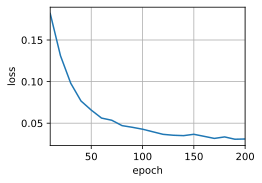

In [18]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

下面来进行一些翻译，并计算BLEU分数

In [22]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => <unk> .,  bleu 0.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000
i love you. => j’ai <unk> .,  bleu 0.000


下面来可视化一下注意力权重，这里的注意力权重形状为`(编码器层数, num_heads, num_steps或查询的数目, num_steps或键值对的数目)`

In [23]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

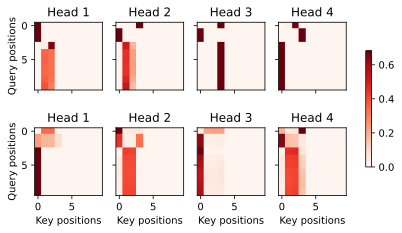

In [24]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [25]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 4, 10]), torch.Size([2, 4, 4, 10]))

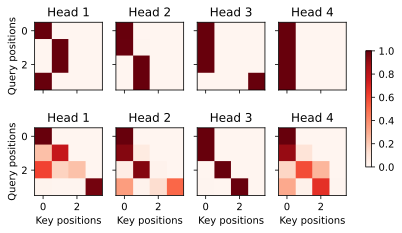

In [26]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

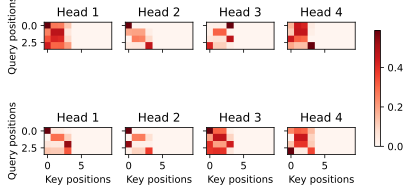

In [27]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

### 10.7.7 小结

- Transformer是编码器－解码器架构的一个实践，尽管在实际情况中编码器或解码器可以单独使用。
- 在Transformer中，多头自注意力用于表示输入序列和输出序列，不过解码器必须通过掩蔽机制来保留自回归属性。
- Transformer中的残差连接和层规范化是训练非常深度模型的重要工具。
- Transformer模型中基于位置的前馈网络使用同一个多层感知机，作用是对所有序列位置的表示进行转换。